# 9. Double Dueling DQN to play Breakout game

_Exercise: Use a Double Dueling DQN to train an agent that can achieve a superhuman level at the famous Atari Breakout game (`"ALE/Breakout-v5"`). The observations are images. To simplify the task, you should convert them to grayscale (i.e., average over the channels axis), crop them and downsample them, so they're just large enough to play, but not much more. An individual image does not tell you which way the ball and the paddles are going, so you should merge two or three consecutive images to form each state. Lastly, the DQN should be composed mostly of convolutional layers._

Check out the [State-of-the-Art for Atari Games on paperswithcode.com](https://paperswithcode.com/task/atari-games).

In [13]:
import gymnasium as gym
import ale_py
gym.register_envs(ale_py)

import matplotlib.pyplot as plt
from collections import deque
import numpy as np
import keras
from keras import layers
import keras.api.ops as K
import tensorflow as tf

np.random.seed(42)
keras.utils.set_random_seed(42)

(210, 160)


A.L.E: Arcade Learning Environment (version 0.10.1+unknown)
[Powered by Stella]


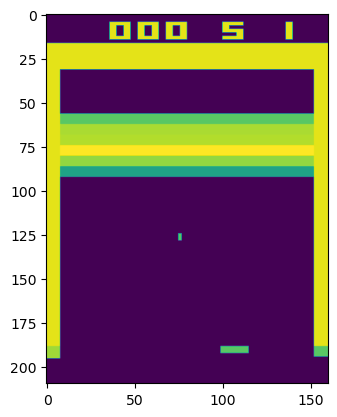

In [2]:
# Use grayscale to simplify task
env = gym.make("ALE/Breakout-v5", render_mode="rgb_array", obs_type="grayscale")
obs, info = env.reset()
obs, reward, terminated, truncated, info = env.step(1)
print(np.array(obs).shape)

# TODO: Crop and downscale (barely playable) - can we use dimension reduction?
plt.imshow(obs)


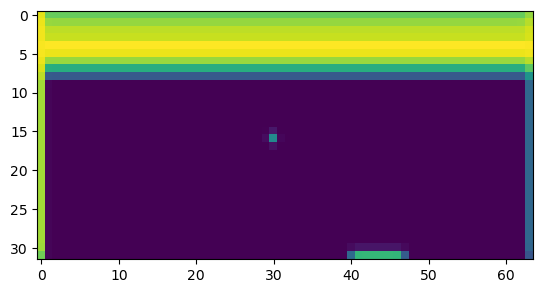

In [5]:
from skimage.transform import resize

cropped_obs = obs[57:193, 6:153]
downscaled_obs = resize(cropped_obs, (32, 64))

plt.imshow(downscaled_obs)

In [18]:
env = gym.make("ALE/Breakout-v5", render_mode="human", full_action_space=False)
env.reset()

for _ in range(100):
    action = env.action_space.sample()

    obs, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        obs, info = env.reset()

env.close()

In [12]:
def build_dqn_model(input_shape, n_outputs):
    # Input layer
    inputs = keras.Input(shape=input_shape)
    
    # Hidden layers
    x = layers.Dense(32, activation="elu")(inputs)
    x = layers.Dense(32, activation="elu")(x)
    
    # State value and advantage streams
    state_values = layers.Dense(1)(x)
    raw_advantages = layers.Dense(n_outputs)(x)
    
    # Calculate advantages using keras.ops instead of tf operations
    advantages = raw_advantages - K.mean(raw_advantages, axis=1, keepdims=True)
    
    # Combine state values and advantages to get Q-values
    outputs = state_values + advantages
    
    # Create and return the model
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

input_shape = env.observation_space.shape
n_outputs = env.action_space.n

model = build_dqn_model(input_shape, n_outputs)

In [15]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)  # random action
    else:
        Q_values = model.predict(state[np.newaxis], verbose=0)[0]
        return Q_values.argmax()  # optimal action according to the DQN

In [ ]:
def play_one_step(env, replay_buffer, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, truncated, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done, truncated))
    return next_state, reward, done, truncated, info

In [ ]:
def sample_experiences(replay_buffer, batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    return [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(6)
    ]  # [states, actions, rewards, next_states, dones, truncateds]

In [17]:
def training_step(target, loss_fn, optimizer, replay_buffer, batch_size, discount_factor):
    experiences = sample_experiences(replay_buffer, batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences

    next_Q_values = model.predict(next_states, verbose=0)
    best_next_actions = next_Q_values.argmax(axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    max_next_Q_values = (target.predict(next_states, verbose=0) * next_mask
                        ).sum(axis=1)

    runs = 1.0 - (dones | truncateds)  # episode is not done or truncated
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [ ]:
batch_size = 32
discount_factor = 0.95
optimizer = keras.optimizers.Nadam(learning_rate=5e-3)
loss_fn = keras.losses.mean_squared_error

target = keras.models.clone_model(model)  # clone the model's architecture
target.set_weights(model.get_weights())  # copy the weights

env.reset(seed=42)
replay_buffer = deque(maxlen=2000)
rewards = []
best_score = 0

for episode in range(600):
    obs, info = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info, truncated = play_one_step(env, replay_buffer, obs, epsilon)
        if done or truncated:
            break

    print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}",
          end="")
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step

    if episode > 50:
        training_step(target, loss_fn, optimizer, replay_buffer, batch_size, discount_factor)
        if episode % 50 == 0:
            target.set_weights(model.get_weights())

model.set_weights(best_weights)